# Data Label

## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

import emoji
import re

## Load data

In [2]:
posts_df = pd.read_csv('..\\data\\all_posts-merged.csv')
comments_df = pd.read_csv('..\\data\\all_comments-merged.csv')
users_df = pd.read_csv('..\\data\\user_data-merged.csv')

In [3]:
display(posts_df.head(1))
display(comments_df.head(1))
display(users_df.head(1))

,subreddit,username,name,title,text,is_original_content,num_comments,score,upvote_ratio,date
0,AskReddit,elevate-digital,t3_1fxlnxv,"Guys with extremely loud vehicles, why do you ...",NaN,False,8421,20664,0.87,2024-10-06 17:20:58


,subreddit,username,body,post_title,score,num_replies,is_submitter,id,parent_id,stickied,date
0,AskReddit,thedudear,I used to own an insanely loud vehicle. A Pont...,"Guys with extremely loud vehicles, why do you ...",2045,6,False,lqpnfpr,t3_1fxlnxv,False,2024-10-07 01:35:59


,username,link_karma,comment_karma,account_age,is_verified
0,yakfsh1,19830.0,88232.0,1440.0,True


In [4]:
comments_df = comments_df.dropna(subset=['body'])

In [5]:
posts_df.columns, comments_df.columns, users_df.columns

(Index(['subreddit', 'username', 'name', 'title', 'text', 'is_original_content',
        'num_comments', 'score', 'upvote_ratio', 'date'],
       dtype='object'),
 Index(['subreddit', 'username', 'body', 'post_title', 'score', 'num_replies',
        'is_submitter', 'id', 'parent_id', 'stickied', 'date'],
       dtype='object'),
 Index(['username', 'link_karma', 'comment_karma', 'account_age',
        'is_verified'],
       dtype='object'))

## Label Bots

### Experiments

In [6]:
usernames_series = pd.Series(users_df['username'])

bot_part = ["bot", "admin", "mod", "auto", "helper", "assist", "news", "alert", "info"]
diggit_pattern = r'[a-zA-Z]+[0-9]{5,}$'  # e.g., "user123456"

pattern = '|'.join(bot_part)

bot_usernames = usernames_series[usernames_series.str.contains(pattern, case=False)]
digit_bot_usernames = usernames_series[usernames_series.str.contains(diggit_pattern)]
unique_bot_usernames = bot_usernames.unique()

print(f"Number usernames with bot pattern: {len(unique_bot_usernames)}")
print(f"Number usernames with digit pattern: {len(digit_bot_usernames)}")

Number usernames with bot pattern: 1152
Number usernames with digit pattern: 1704


In [7]:
posts_per_user = posts_df['username'].value_counts()
comments_per_user = comments_df['username'].value_counts()

posts_median = posts_per_user.mean()
comments_median = comments_per_user.mean()

posts_above_median = posts_per_user[posts_per_user > posts_median]
comments_above_median = comments_per_user[comments_per_user > comments_median]

print(f"Number of users with more posts than median: {len(posts_above_median)}")
print(f"Number of users with more comments than median: {len(comments_above_median)}")

Number of users with more posts than median: 114
Number of users with more comments than median: 59595


In [8]:
users_with_low_karma = users_df[(users_df['link_karma'] < -10) | (users_df['comment_karma'] < -10)]

print(f"Number of users with low karma: {len(users_with_low_karma)}")

Number of users with low karma: 408


### Bot identification

In [9]:
def count_slashes_and_emojis(df_comments):
    # Weird looking comments indicate bots
    df_comments = df_comments.copy()
    
    def count_special_chars(text):
        backslashes = text.count('\\')
        forwardslashes = text.count('/')
        emojis = len([char for char in text if emoji.is_emoji(char)])
        return backslashes + forwardslashes, emojis

    df_comments[['slashes', 'emojis']] = df_comments['body'].apply(
        lambda x: pd.Series(count_special_chars(x))
    )
    df_comments['slashes_emojis'] = df_comments['slashes'] + df_comments['emojis']

    return df_comments

def get_bot_usernames_from_comments(comments_df):
    com = count_slashes_and_emojis(comments_df)

    user_averages = com.groupby('username').agg({
        'emojis': 'mean',
        'slashes': 'mean',
        'slashes_emojis': 'mean'
    }).rename(columns={'emojis': 'avg_emojis', 'slashes': 'avg_slashes', 'slashes_emojis': 'avg_slashes_emojis'})

    filtered_users = user_averages[
        (user_averages['avg_slashes'] > 6) |
        (user_averages['avg_emojis'] > 5) |
        (user_averages['avg_slashes_emojis'] > 8)
    ]

    users_with_high_slashes = com[com['slashes'] > 10]['username'].unique()
    users_with_high_emojis = com[com['emojis'] > 10]['username'].unique()
    users_with_high_slashes_emojis = com[com['slashes_emojis'] > 15]['username'].unique()
    unique_usernames = set(filtered_users.index) | set(users_with_high_slashes) | set(users_with_high_emojis) | set(users_with_high_slashes_emojis)

    print(f"Number of bot usernames from comments: {len(unique_usernames)}")
    return list(unique_usernames)


In [12]:
def autolabel_bots(df_posts, df_comments, df_user_info):

    df_combined = pd.concat([df_posts[['username', 'subreddit', 'title', 'text', 'score', 'upvote_ratio']],
                             df_comments[['username', 'subreddit', 'body', 'score']]])

    user_activity = df_combined.groupby('username').agg({
        'title': 'count',
        'text': 'count',
        'body': 'count',
        'score': 'mean',
        'upvote_ratio': 'mean'
    }).rename(columns={'title': 'num_posts', 'text': 'num_texts', 'body': 'num_comments', 'score': 'avg_score', 'upvote_ratio': 'avg_upvote_ratio'}).fillna(0)

    df_users = pd.merge(df_user_info, user_activity, on='username', how='left').fillna(0)

    bot_usernames = ['bot', 'auto', 'mod', 'helper', 'AI', 'assist', 'news', 'alert', 'info']
    username_pattern = re.compile(r'\b(' + '|'.join(bot_usernames) + r')\b', re.IGNORECASE)
    username_with_digits_pattern = re.compile(r'[a-zA-Z]+[0-9]{5,}$')  # e.g., "user123456"

    counters = {
        'username_pattern': 0,
        'high_posting_frequency': 0,
        'high_activity_new_account': 0,
        'low_karma': 0,
        'low_avg_score': 0,
        'consistent_upvote': 0,
        'karma_ratio': 0,
        'repetitive_content': 0,
    }

    def is_bot(row):

        validaion_count = 0
        
        # Username patterns
        if username_pattern.search(row['username']) or username_with_digits_pattern.search(row['username']):
            counters['username_pattern'] += 1
            return True
        
        # Account age with high activity
        if row['account_age'] < 60 and row['num_posts'] + row['num_comments'] > 100:
            counters['high_activity_new_account'] += 1
            validaion_count += 1

        # Low karma
        if row['link_karma'] < -30 or row['comment_karma'] < -30:
            counters['low_karma'] += 1
            validaion_count += 1
            if validaion_count > 1:
                return True

        # Frequent low scores indicating low engagement
        if row['avg_score'] < 0.5 and row['num_posts'] + row['num_comments'] > 10:  # Average score threshold for spammy content
            counters['low_avg_score'] += 1
            validaion_count += 1
            if validaion_count > 1:
                return True
        # Consistent upvote ratios (either too low or too high)
        if (row['avg_upvote_ratio'] < 0.05 or row['avg_upvote_ratio'] > 0.96) and row['avg_upvote_ratio'] != 0:
            counters['consistent_upvote'] += 1
            validaion_count += 1
            if validaion_count > 1:
                return True
        
        if row['link_karma'] > 50 * row['comment_karma']:
            counters['karma_ratio'] += 1
            validaion_count += 1
            if validaion_count > 1:
                return True


        return False

    df_users['is_bot'] = df_users.apply(is_bot, axis=1)

    print("Counters:", counters)
    
    return df_users

In [13]:
def mark_bots(df_posts, df_comments, df_user):
    unique_usernames = get_bot_usernames_from_comments(df_comments)
    labeled_users = autolabel_bots(df_posts, df_comments, df_user)

    labeled_users.loc[labeled_users['username'].isin(unique_usernames), 'is_bot'] = True

    return labeled_users

In [14]:
labeled_users = mark_bots(posts_df, comments_df, users_df)  # aprox: 

Number of bot usernames from comments: 623
Counters: {'username_pattern': 1736, 'high_posting_frequency': 0, 'high_activity_new_account': 2, 'low_karma': 194, 'low_avg_score': 42, 'consistent_upvote': 101, 'karma_ratio': 2694, 'repetitive_content': 0}


In [15]:
len(labeled_users[labeled_users['is_bot'] == True]), len(labeled_users['is_bot'])

(2563, 194750)

-----------------------------------

### General Analysis

In [47]:
com = count_slashes_and_emojis(comments_df)

In [48]:
print(f"Number of comments with more than 3 slashes: {len(com[com['slashes'] > 3])}")
print(f"Number of comments with more than 3 emojis: {len(com[com['emojis'] > 3])}")

Number of comments with more than 3 slashes: 1693
Number of comments with more than 3 emojis: 358


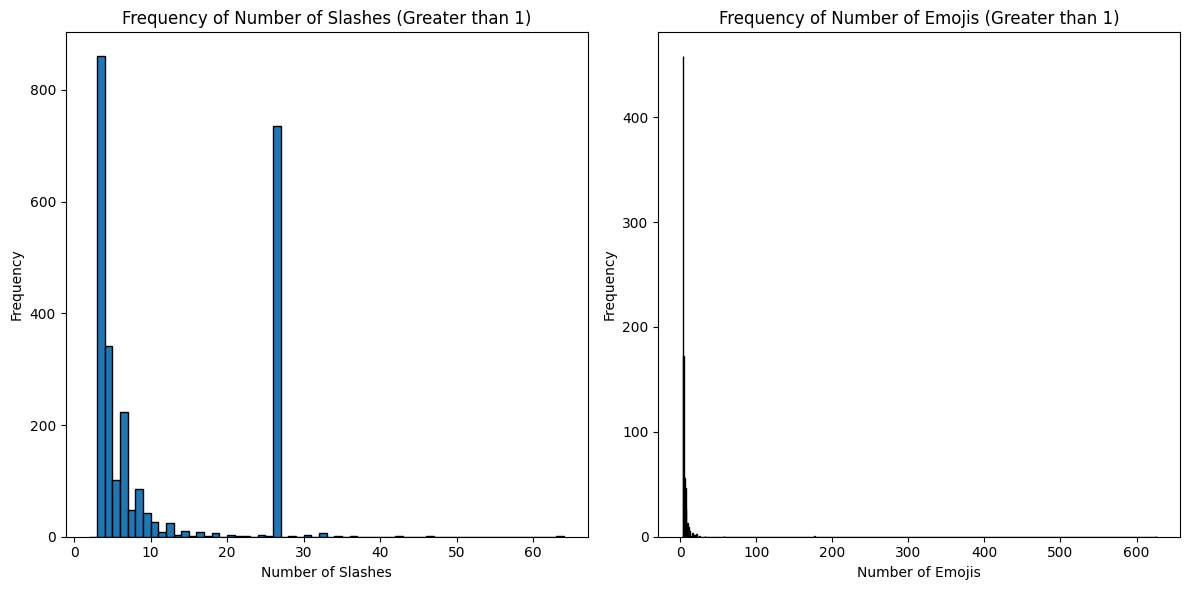

In [ ]:
filtered_com_slashes = com[com['slashes'] > 2]
filtered_com_emojis = com[com['emojis'] > 2]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(filtered_com_slashes['slashes'], bins=range(2, max(filtered_com_slashes['slashes']) + 1), edgecolor='black')
plt.title('Frequency of Number of Slashes (Greater than 1)')
plt.xlabel('Number of Slashes')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(filtered_com_emojis['emojis'], bins=range(2, max(filtered_com_emojis['emojis']) + 1), edgecolor='black')
plt.title('Frequency of Number of Emojis (Greater than 1)')
plt.xlabel('Number of Emojis')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

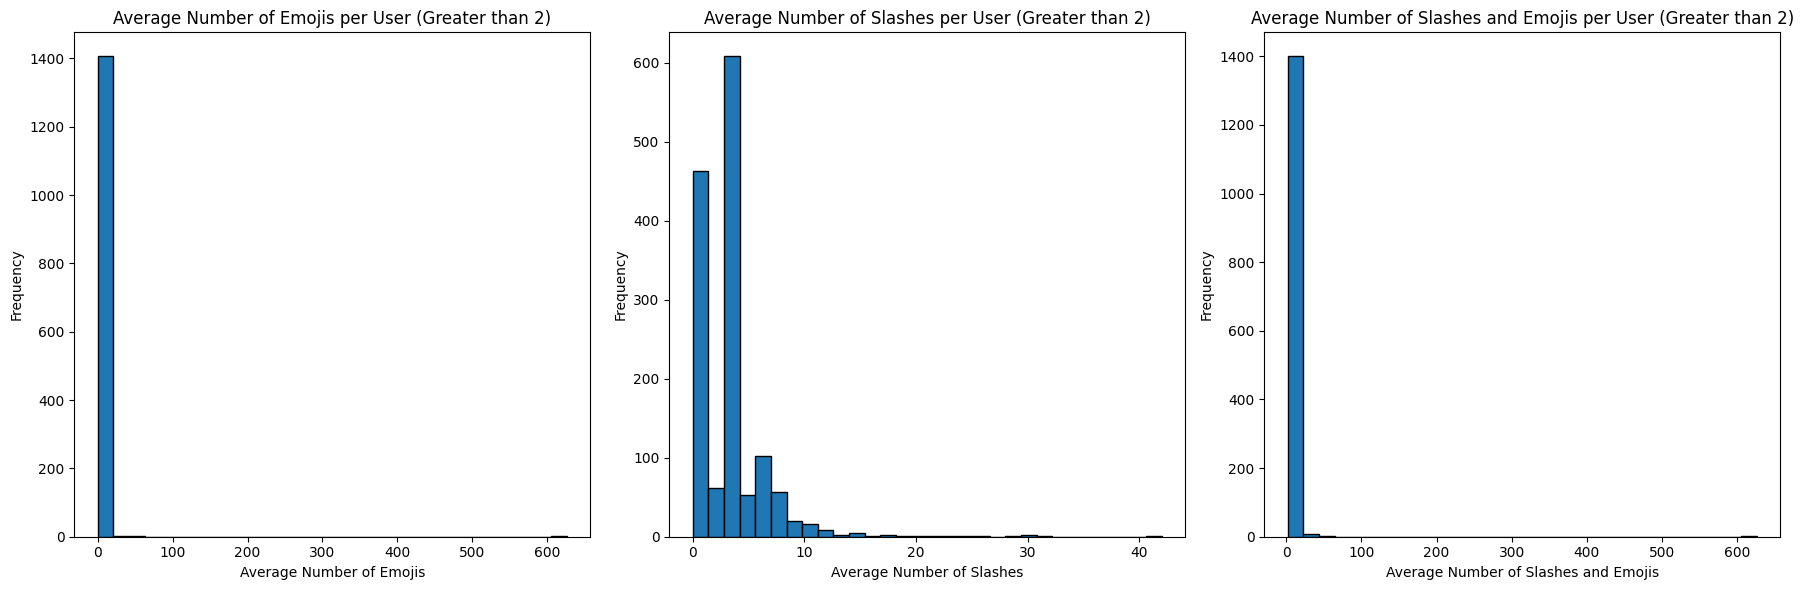

In [ ]:
user_averages = com.groupby('username').agg({
    'emojis': 'mean',
    'slashes': 'mean'
}).rename(columns={'emojis': 'avg_emojis', 'slashes': 'avg_slashes'})
user_averages['avg_slashes_emojis'] = user_averages['avg_emojis'] + user_averages['avg_slashes']

filtered_user_averages = user_averages[(user_averages['avg_emojis'] > 2) | (user_averages['avg_slashes'] > 2) | (user_averages['avg_slashes_emojis'] > 2)]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(filtered_user_averages['avg_emojis'], bins=30, edgecolor='black')
plt.title('Average Number of Emojis per User (Greater than 2)')
plt.xlabel('Average Number of Emojis')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(filtered_user_averages['avg_slashes'], bins=30, edgecolor='black')
plt.title('Average Number of Slashes per User (Greater than 2)')
plt.xlabel('Average Number of Slashes')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(filtered_user_averages['avg_slashes_emojis'], bins=30, edgecolor='black')
plt.title('Average Number of Slashes and Emojis per User (Greater than 2)')
plt.xlabel('Average Number of Slashes and Emojis')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
user_averages = com.groupby('username').agg({
    'emojis': 'mean',
    'slashes': 'mean'
}).rename(columns={'emojis': 'avg_emojis', 'slashes': 'avg_slashes'})
user_averages['avg_slashes_emojis'] = user_averages['avg_emojis'] + user_averages['avg_slashes']

num_users_with_high_avg_slashes = len(user_averages[user_averages['avg_slashes'] > 5])
print(f"Number of users with avg_slashes greater than 3: {num_users_with_high_avg_slashes}")

num_users_with_high_avg_emojis = len(user_averages[user_averages['avg_emojis'] > 3])
print(f"Number of users with avg_emojis greater than 3: {num_users_with_high_avg_emojis}")

num_users_with_high_avg_slashes_emojis = len(user_averages[user_averages['avg_slashes_emojis'] > 7])
print(f"Number of users with avg_slashes_emojis greater than 3: {num_users_with_high_avg_slashes_emojis}")


Number of users with avg_slashes greater than 3: 229
Number of users with avg_emojis greater than 3: 202
Number of users with avg_slashes_emojis greater than 3: 139


In [ ]:
filtered_com = com[com['slashes'] > 10]

num_unique_users = filtered_com['username'].nunique()
print(f"Number of unique users with more than 10 slashes in a single comment: {num_unique_users}")

filtered_com = com[com['emojis'] > 10]

num_unique_users = filtered_com['username'].nunique()
print(f"Number of unique users with more than 10 slashes in a single comment: {num_unique_users}")

Number of unique users with more than 10 slashes in a single comment: 76
Number of unique users with more than 10 slashes in a single comment: 21
